In [75]:
import numpy as np
import pandas as pd
import os
import time
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans

<h3> 1. Load Data set </h3>

In [76]:
input_path = "gs://agriculture-sara/Test_manual.csv"
df = pd.read_csv(input_path, delimiter=',')
df.head()

#Drop un-needed columns
columnsToDrop = ['Date', 'Site Id','Year','Month','Day',
                 'G','G-1','G-2','G-3','G-4','G-5',
                 'H', 'H_CORRECTED-1', 'H_CORRECTED-2', 'H_CORRECTED-3', 'H_CORRECTED-4',
                 'H_CORRECTED-5',
                 'NETRAD','NETRAD-1','NETRAD-2','NETRAD-3','NETRAD-4','NETRAD-5',
                 'LE', 'LE_CORRECTED(mm)-1', 'LE_CORRECTED(mm)-2', 'LE_CORRECTED(mm)-3', 'LE_CORRECTED(mm)-4',
                'LE_CORRECTED(mm)-5']

# columnsToDrop = ['Date', 'Site Id','Year','Month','Day','LE_bowen_corr(mm)',
#                  'G','G-1','G-2','G-3','G-4','G-5',
#                  'H','H_ebr_corr','H_ebr_corr-1','H_ebr_corr-2','H_ebr_corr-3','H_ebr_corr-4','H_ebr_corr-5',
#                  'NETRAD','NETRAD-1','NETRAD-2','NETRAD-3','NETRAD-4','NETRAD-5',
#                  'LE','LE_ebr_corr','ET_ebr','ET_ebr_corr','ET_ebr_corr(mm)','ETrF',
#                  'Elevation','Longitude','Latitude','Climate','Vegetation',
#                  'H_bowen_corr','H_bowen_corr-1','H_bowen_corr-2','H_bowen_corr-3',
#                  'H_bowen_corr-4','H_bowen_corr-5', 'LE_bowen_corr','ET_bowen',
#                  'ET_bowen_corr','ET_bowen_corr(mm)']

df = df.drop(columnsToDrop, axis = 1)

#Drop NaN values
df.dropna(inplace=True)

df.rename(columns={"Site Id_1": "Site_1", "Site Id_2": "Site_2",
                  "Site Id_3": "Site_3", "Site Id_4": "Site_4",
                  "Site Id_5": "Site_5", "Site Id_6": "Site_6"}, inplace=True)

#Specify the output feature
output_column = "LE_CORRECTED(mm)"

<h3> 2. Compute the average of the lags of weather columnns </h3>

In [77]:
def get_matching_columns(keyword):
    '''
    Get the columns containing the specified keyword
    '''
    return [col for col in df.columns if keyword in col]

#Get all lags of relative humidity columns
rh_columns = get_matching_columns("RH-")
#Get all lags of wind speed columns
ws_columns = get_matching_columns("WS-")
#Get all lags of air temperature columns
ta_columns = get_matching_columns("TA-")

#Compute the average of the relative humidity lags
df['RH_avg'] = df[rh_columns].mean(axis=1)
#Compute the average of the wind speed lags
df['WS_avg'] = df[ws_columns].mean(axis=1)
#Compute the average of the air temperature lags
df['TA_avg'] = df[ta_columns].mean(axis=1)

print(rh_columns, ws_columns, ta_columns)
print(df.columns)

['RH-1', 'RH-2', 'RH-3', 'RH-4', 'RH-5'] ['WS-1', 'WS-2', 'WS-3', 'WS-4', 'WS-5'] ['TA-1', 'TA-2', 'TA-3', 'TA-4', 'TA-5']
Index(['WS', 'WS-1', 'WS-2', 'WS-3', 'WS-4', 'WS-5', 'RH', 'RH-1', 'RH-2',
       'RH-3', 'RH-4', 'RH-5', 'TA', 'TA-1', 'TA-2', 'TA-3', 'TA-4', 'TA-5',
       'H_CORRECTED', 'LE_CORRECTED', 'LE_CORRECTED(mm)', 'C_BOWENS',
       'Climate_1', 'Climate_2', 'Climate_3', 'Site_1', 'Site_2', 'Site_3',
       'Site_4', 'Site_5', 'Month_1', 'Month_2', 'Month_3', 'Month_4',
       'RH_avg', 'WS_avg', 'TA_avg'],
      dtype='object')


<h3> 3. Specify the columns to study </h3>

In [78]:
df_temp = df[["RH", "WS", "TA", "RH_avg", "WS_avg", "TA_avg", output_column]]
df_temp.head()

RH        WS         TA     RH_avg    WS_avg     TA_avg  \
0  60.558889  7.035578  30.300000  67.114770  4.506707  28.294762   
1  44.675714  4.792957  32.134286  62.930048  5.244022  29.327762   
2  46.370000  7.037743  32.742857  57.163635  5.507029  30.585286   
3  49.903750  5.792850  31.801250  53.577635  6.236790  31.321857   
4  58.570000  4.921540  28.681000  52.866671  6.196346  31.398679   

   LE_CORRECTED(mm)  
0          5.083154  
1          5.165179  
2          5.346822  
3          4.097326  
4          4.706642

<h3> 4. Split the data into input and ouput features </h3>

In [79]:
X = df_temp.drop([output_column], axis = 1)
Y = df_temp[output_column]
print(X.shape, Y.shape)

(12074, 6) (12074,)


In [80]:
print(df_temp.isna().sum())
df_temp.describe()

RH                  0
WS                  0
TA                  0
RH_avg              0
WS_avg              0
TA_avg              0
LE_CORRECTED(mm)    0
dtype: int64


RH            WS            TA        RH_avg        WS_avg  \
count  12074.000000  12074.000000  12074.000000  12074.000000  12074.000000   
mean      63.053613      3.072717     19.232713     63.978842      3.067874   
std       15.209466      1.741018      6.816767     12.063513      1.417615   
min        8.800000      0.000000      1.457667     11.437917      0.166847   
25%       53.485066      1.758713     14.050951     56.697175      1.898511   
50%       64.322940      2.590402     19.488157     64.929912      2.769364   
75%       73.642334      4.047438     24.483638     72.224953      4.056295   
max      100.000000     12.714425     37.310000     97.219266      9.278394   

             TA_avg  LE_CORRECTED(mm)  
count  12074.000000      12074.000000  
mean      19.123060          4.513926  
std        6.436705          2.782564  
min        3.398030          1.000008  
25%       14.005514          2.218856  
50%       19.414101          3.907021  
75%       24.090276          6.146374  
max       36.349681         14.934017

<h3> 5. Normalize data </h3>

In [81]:
scaler = MinMaxScaler((0,1))
X_scaled = scaler.fit_transform(X)

In [82]:
kmeans = KMeans(n_clusters=4, precompute_distances=True, random_state=0, verbose=0)
kmeans.fit(X_scaled)
y_kmeans = kmeans.predict(X_scaled)

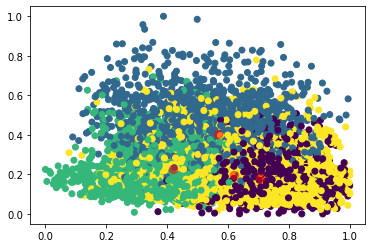

In [83]:
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=y_kmeans, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=70, alpha=0.5);

In [84]:
kmeans.labels_

array([2, 2, 2, ..., 2, 2, 2], dtype=int32)

Elbow Method: A method to choose the best number of clusters which depends on computing Within cluster
Sum of Squares (WCSS), it is defined as the sum of the squared distance between each member of the cluster and its centroid.

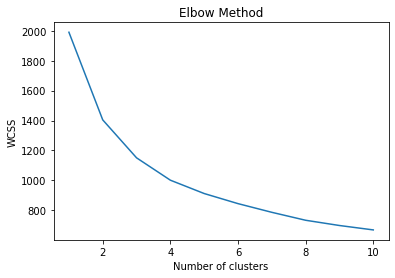

In [85]:
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

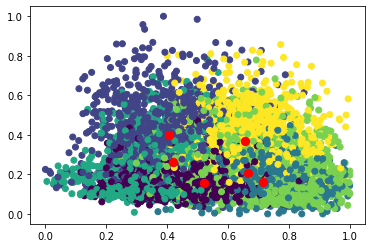

In [86]:
kmeans = KMeans(n_clusters=6, init='k-means++', max_iter=300, n_init=10, random_state=0)
pred_y = kmeans.fit_predict(X_scaled)
plt.scatter(X_scaled[:,0], X_scaled[:,1], c=pred_y, cmap='viridis')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=70, c='red')
plt.show()

Reference:
<ul>
    <li>https://towardsdatascience.com/machine-learning-algorithms-part-9-k-means-example-in-python-f2ad05ed5203 </li>
    <li> https://jakevdp.github.io/PythonDataScienceHandbook/05.11-k-means.html </li>
    <li> https://datatofish.com/k-means-clustering-python/</li>
</ul>